[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/12oJvjjdJIXN1YAySF1LhfFgJ3dG0uHHT?usp=sharing) 


# I. Setup

In [1]:
!nvidia-smi

Fri Dec 17 10:52:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.09       Driver Version: 497.09       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P5    N/A /  N/A |    682MiB /  4096MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
from tensorflow.keras.utils import Sequence
import cv2
import tensorflow as tf 
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.cluster import KMeans
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import * 
from tensorflow.keras.applications import MobileNetV2
import glob2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from tensorflow.keras.metrics import MeanIoU


# II. Defind function and Class

In [13]:
def cvtColor(x):
    x[x < 255] = 0
    return x

In [14]:
def func(img):
    d = list(map(lambda x: cvtColor(x), img.reshape(-1,3)))
    return np.array(d).reshape(*img.shape[:-1], 3)

In [17]:
class DataGenerator(Sequence):
    def __init__(self, all_filenames, input_size = (256, 256), batch_size = 32, shuffle = True, seed = 123, encode: dict = None, color_mode = 'hsv', function = None) -> None:
        super(DataGenerator, self).__init__()
        assert encode != None,  'Not empty !'
        assert color_mode == 'hsv' or color_mode == 'rgb' or color_mode == 'gray'
        self.all_filenames = all_filenames
        self.input_size = input_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.color_mode = color_mode
        self.encode = encode
        self.function = function
        np.random.seed(seed)
        self.on_epoch_end()
    def processing(self, mask):
        d = list(map(lambda x: self.encode[tuple(x)], mask.reshape(-1,3)))
        return np.array(d).reshape(*self.input_size, 1)
    def __len__(self):
        return int(np.floor(len(self.all_filenames) / self.batch_size))
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        all_filenames_temp = [self.all_filenames[k] for k in indexes]
        X, Y = self.__data_generation(all_filenames_temp)
        return X, Y
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, all_filenames_temp):
        batch = len(all_filenames_temp)
        if self.color_mode == 'gray':
            X = np.empty(shape=(batch, *self.input_size, 1))
        else:
            X = np.empty(shape=(batch, *self.input_size,3))
        Y = np.empty(shape=(batch, *self.input_size, 1))
        for i, (fn, label_fn) in enumerate(all_filenames_temp):
            # img
            img = cv2.imread(fn)
            if self.color_mode == 'hsv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif self.color_mode == 'rgb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif self.color_mode == 'gray':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = tf.expand_dims(img, axis = 2)
            img = tf.image.resize(img, self.input_size, method = 'nearest')
            img = tf.cast(img, tf.float32)
            img /= 255.
            
            #mask
            mask = cv2.imread(label_fn, 0)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = tf.image.resize(mask, self.input_size, method= 'nearest')
            mask = np.array(mask)
            if self.function:
                mask = self.function(mask)
            mask = self.processing(mask)
            mask = tf.cast(mask, tf.float32)
            X[i,] = img
            Y[i,] = mask
        return X, Y

In [3]:
def encode_label(mask):
    # input (batch, rows, cols, channels)
    colors = np.unique(mask.reshape(-1,3), axis = 0)
    encoder = dict((tuple(j),i) for i,j in enumerate(colors)) # key is tuple 
    _label = dict((j, list(i)) for i,j in encoder.items())
    with open('label.pickle', 'wb') as handel:
        pickle.dump(_label, handel, protocol= pickle.HIGHEST_PROTOCOL)
    return encoder
def decode_label(predict, label):
    d = list(map( lambda x: label[int(x)], predict.reshape(-1,1)))
    img =  np.array(d).reshape(predict.shape[0], predict.shape[1], 3)
    return img
def DataLoader(all_train_filename, all_mask,  all_valid_filename = None, input_size = (256,256), batch_size = 4, shuffle = True, seed = 123, color_mode = 'hsv', function = None) -> None:
    mask_folder = sklearn.utils.shuffle(all_mask, random_state = 47)[:16]
    mask = [tf.image.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), input_size, method = 'nearest') for img in mask_folder ]
    mask = np.array(mask)
    if function:
        mask = function(mask)
    encode = encode_label(mask)
    train = DataGenerator(all_train_filename, input_size, batch_size , shuffle, seed, encode, color_mode, function)
    if all_valid_filename == None: 
        return train, None
    else:
        valid = DataGenerator(all_valid_filename, input_size, batch_size, shuffle, seed, encode, color_mode, function)
        return train, valid

In [6]:
def decoder_block(x, y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis = 3)([x,y])
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    return x

def mobilenetv2_unet(input_shape, *, classes, dropout):    ## (512, 512, 3)
    inputs = Input(shape=input_shape)
    """ Pre-trained MobileNetV2 """
    encoder = MobileNetV2(include_top=False, weights="imagenet",
        input_tensor=inputs, alpha=1.0)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output                
    s2 = encoder.get_layer("block_1_expand_relu").output    
    s3 = encoder.get_layer("block_3_expand_relu").output   
    s4 = encoder.get_layer("block_6_expand_relu").output   

    
    x = encoder.get_layer("block_13_expand_relu").output   

    """ Decoder """
    x = decoder_block(x, s4, 512)                         
    x = decoder_block(x, s3, 256)                         
    x = decoder_block(x, s2, 128)                        
    x = decoder_block(x, s1, 64)                         

    x = Dropout(dropout)(x)
    outputs = Conv2D(classes, 1, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="MobileNetV2_U-Net")
    return model

In [5]:
class m_iou():
    def __init__(self, classes: int) -> None:
        self.classes = classes
    def mean_iou(self,y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        return miou_keras.result().numpy()
    def miou_class(self, y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)        
        values = np.array(miou_keras.get_weights()).reshape(self.classes, self.classes)
        for i in  range(self.classes):
            class_iou = values[i,i] / (sum(values[i,:]) + sum(values[:,i]) - values[i,i])
            print(f'IoU for class{str(i + 1)} is: {class_iou}')

In [16]:
import matplotlib.pyplot as plt 
def show_history(history, validation : bool = False):
    if validation:
        # Loss
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        axes.legend()
        # Acc
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['acc'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_acc'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Acc')
        axes.legend()
        # Mean Iou
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['mean_iou'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_mean_iou'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('MeanIoU')
        axes.legend()
    else:
        fig, axes = plt.subplots(1,4, figsize= (20,5))
        # loss
        axes[0].plot(history.epoch, history.history['loss'])
        axes[0].set_title('Train')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        # Acc
        axes[1].plot(history.epoch, history.history['acc'])
        axes[1].set_title('Train')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Acc')
        # Mean Iou
        axes[2].plot(history.epoch, history.history['mean_iou'])
        axes[2].set_title('Train')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MeanIoU')

In [23]:
def predict(model, image_test, label, color_mode, size):
    image = cv2.imread(image_test)
    if color_mode == 'hsv':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_mode == 'rgb':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_mode == 'gray':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_cvt = tf.expand_dims(image_cvt, axis = 2)
    image_cvt = tf.image.resize(image_cvt, size, method= 'nearest')
    image_cvt = tf.cast(image_cvt, tf.float32) 
    image_norm = image_cvt / 255.
    image_norm = tf.expand_dims(image_norm, axis= 0)
    new_image = model(image_norm)
    image_argmax = np.argmax(tf.squeeze(new_image, axis = 0), axis = 2)
    image_decode = decode_label(image_argmax, label)
    predict_img = tf.cast(tf.image.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), size, method = 'nearest'), tf.float32) * 0.7 + image_decode * 0.3
    return np.floor(predict_img).astype('int'), new_image

In [24]:
def show_example(image, mask, model, label, inp_size, color_mode, function):
    img = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, inp_size, method ='nearest')
    pred, _pred= predict(model, image, label, color_mode, inp_size)
    if mask != None:
        msk= cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2RGB)
        msk= tf.image.resize(msk, inp_size, method = 'nearest')
        if function:
            msk = tf.convert_to_tensor(function(msk.numpy()))
        y_true = train_data.processing(msk.numpy())
        m.miou_class(y_true, _pred)
        y_true = decode_label(y_true, label)
        ground_truth = np.floor(img.numpy() * 0.7 + y_true * 0.3).astype('int')
        fig, axes = plt.subplots(1,3, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Ground truth')
        axes[1].imshow(ground_truth)
        axes[2].set_title('Prediction')
        axes[2].imshow(pred)

    else:
        fig, axes = plt.subplots(1,2, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Prediction')
        axes[1].imshow(pred)
    

# III. Prepare data to train

In [4]:
images = sorted(glob2.glob('frames/*.jpg'))
masks = sorted(glob2.glob('masks/*.jpg'))
data = list(zip(images, masks))
data = shuffle(data, random_state= 42)
split = int(0.9 * len(data))
all_train_filenames = data[:split]
all_valid_filenames = data[split:]

In [9]:
train_data, valid_data = DataLoader(all_train_filenames, masks, all_valid_filenames, (128, 128), 8, True, 47, 'rgb', function= func)
inp_size = (128, 128, 3)
unet = mobilenetv2_unet(inp_size, classes= 2, dropout= 0.3)

In [6]:
m = m_iou(2)

In [12]:
checkpoint = ModelCheckpoint('mobile_unet.h5', monitor= 'val_mean_iou', save_best_only= True, verbose= 1, mode = 'max')
lr_R = ReduceLROnPlateau(monitor= 'loss', patience= 4, verbose= 1, factor= 0.3, min_lr= 0.00001)

# IV. Train

In [13]:
unet.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), metrics= [m.mean_iou, 'acc'], run_eagerly= True)
history = unet.fit(train_data, validation_data= valid_data, epochs= 70, verbose= 1, callbacks = [checkpoint, lr_R])

Epoch 1/70
307/307 [==============================] - ETA: 0s - loss: 0.0582 - mean_iou: 0.5444 - acc: 0.9820
Epoch 00001: val_mean_iou improved from -inf to 0.49275, saving model to mobile_unet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 272s 874ms/step - loss: 0.0582 - mean_iou: 0.5444 - acc: 0.9820 - val_loss: 0.8751 - val_mean_iou: 0.4928 - val_acc: 0.9855 - lr: 0.1000
Epoch 2/70
307/307 [==============================] - ETA: 0s - loss: 0.0376 - mean_iou: 0.6157 - acc: 0.9865
Epoch 00002: val_mean_iou improved from 0.49275 to 0.49280, saving model to mobile_unet.h5
307/307 [==============================] - 271s 881ms/step - loss: 0.0376 - mean_iou: 0.6157 - acc: 0.9865 - val_loss: 0.3604 - val_mean_iou: 0.4928 - val_acc: 0.9856 - lr: 0.1000
Epoch 3/70
307/307 [==============================] - ETA: 0s - loss: 0.0323 - mean_iou: 0.6616 - acc: 0.9880
Epoch 00003: val_mean_iou did not improve from 0.49280
307/307 [==============================] - 271s 880ms/step - loss: 0.0323 - mean_iou: 0.6616 - acc: 0.9880 - val_loss: 0.4335 - val_mean_iou: 0.4847 - val_acc: 0.9677 - lr: 0.1000
Epoch 4/70
307/307 [==============================] - ETA: 0s - loss: 0.0284 - mean_iou: 0.700

307/307 [==============================] - 271s 881ms/step - loss: 0.0138 - mean_iou: 0.8301 - acc: 0.9945 - val_loss: 0.0199 - val_mean_iou: 0.7974 - val_acc: 0.9931 - lr: 0.0300
Epoch 25/70
307/307 [==============================] - ETA: 0s - loss: 0.0138 - mean_iou: 0.8318 - acc: 0.9945
Epoch 00025: val_mean_iou did not improve from 0.79739
307/307 [==============================] - 280s 913ms/step - loss: 0.0138 - mean_iou: 0.8318 - acc: 0.9945 - val_loss: 0.1685 - val_mean_iou: 0.5458 - val_acc: 0.9294 - lr: 0.0300
Epoch 26/70
307/307 [==============================] - ETA: 0s - loss: 0.0141 - mean_iou: 0.8262 - acc: 0.9944
Epoch 00026: val_mean_iou did not improve from 0.79739
307/307 [==============================] - 279s 909ms/step - loss: 0.0141 - mean_iou: 0.8262 - acc: 0.9944 - val_loss: 0.0935 - val_mean_iou: 0.6051 - val_acc: 0.9599 - lr: 0.0300
Epoch 27/70
307/307 [==============================] - ETA: 0s - loss: 0.0134 - mean_iou: 0.8341 - acc: 0.9946
Epoch 00027: val_

307/307 [==============================] - ETA: 0s - loss: 0.0085 - mean_iou: 0.8834 - acc: 0.9964
Epoch 00047: val_mean_iou did not improve from 0.84717
307/307 [==============================] - 269s 874ms/step - loss: 0.0085 - mean_iou: 0.8834 - acc: 0.9964 - val_loss: 0.0145 - val_mean_iou: 0.8412 - val_acc: 0.9951 - lr: 0.0090
Epoch 48/70
307/307 [==============================] - ETA: 0s - loss: 0.0085 - mean_iou: 0.8855 - acc: 0.9965
Epoch 00048: val_mean_iou improved from 0.84717 to 0.84734, saving model to mobile_unet.h5
307/307 [==============================] - 269s 876ms/step - loss: 0.0085 - mean_iou: 0.8855 - acc: 0.9965 - val_loss: 0.0136 - val_mean_iou: 0.8473 - val_acc: 0.9951 - lr: 0.0090
Epoch 49/70
307/307 [==============================] - ETA: 0s - loss: 0.0085 - mean_iou: 0.8844 - acc: 0.9964
Epoch 00049: val_mean_iou did not improve from 0.84734
307/307 [==============================] - 273s 888ms/step - loss: 0.0085 - mean_iou: 0.8844 - acc: 0.9964 - val_loss:

# V. Predict and show history

In [7]:
with open('label.pickle', 'rb') as handel:
    label = pickle.load(handel)

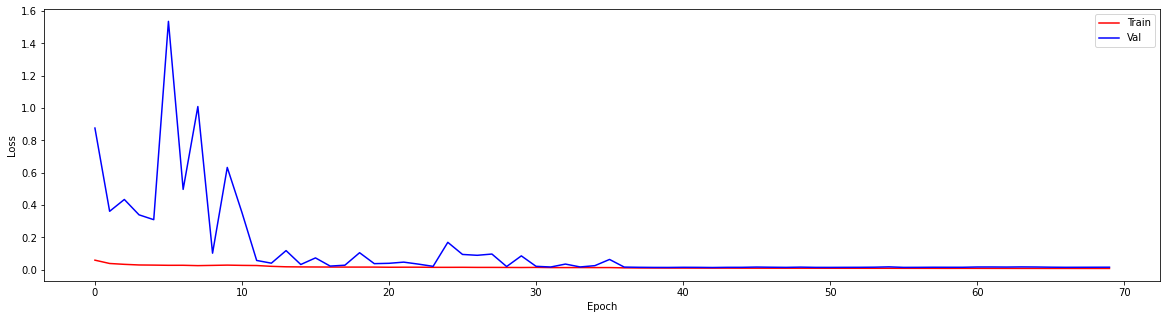

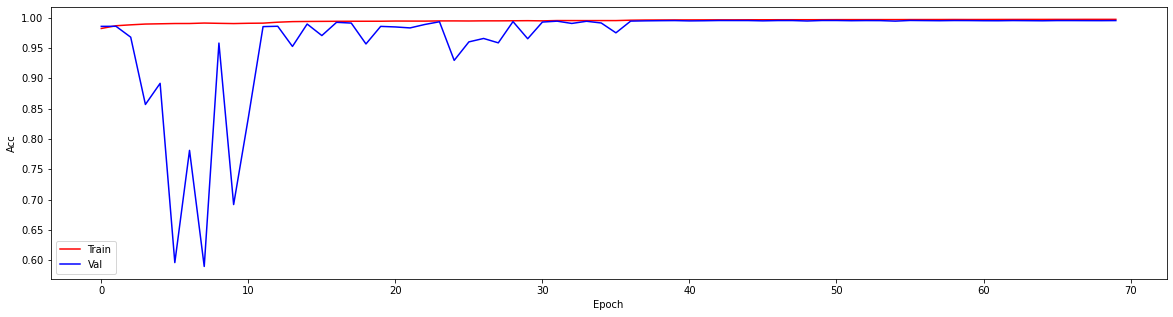

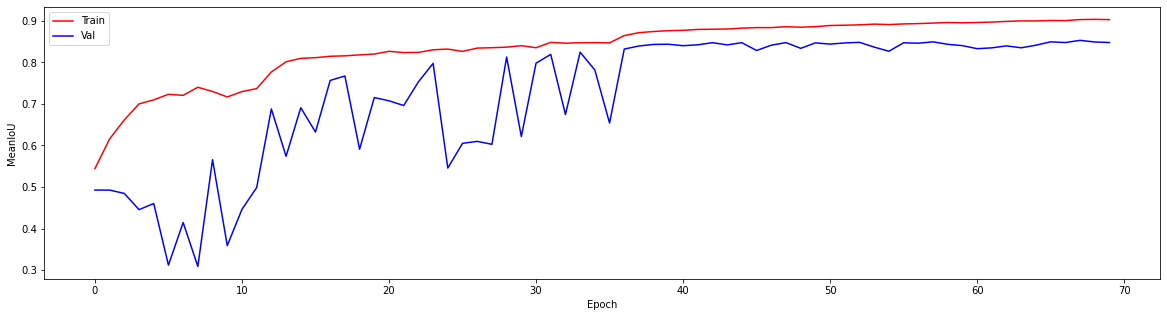

In [19]:
show_history(history, True)

In [10]:
from tensorflow.keras.models import load_model
model = load_model('mobile_unet.h5', custom_objects = {'mean_iou': m.mean_iou})

decode shape: (1, 128, 128, 3)
(128, 128, 3) (1, 128, 128, 2)
IoU for class1 is: 0.9966311061201573
IoU for class2 is: 0.8679706601466992


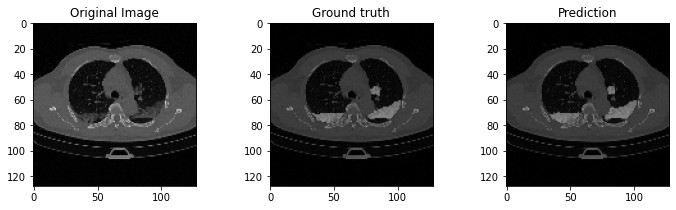

In [25]:
show_example(*all_valid_filenames[0], model, label, (128, 128), 'rgb', func)